# [玉山人工智慧公開挑戰賽2019秋季賽,真相只有一個 -『信用卡盜刷偵測』](https://tbrain.trendmicro.com.tw/Competitions/Details/10)

## <font color=red>任務:預測某刷卡交易是否為盜刷</font>

### Task Schedule:
1. 讀取資料,將字串轉換成int
2. EDA(exploratory data analysis)
3. Feature engineering
4. 訓練模型,調整參數(預計使用lgb，速度較快)
5. 嘗試使用不同模型,做Ensamble(blending, stacking)
6. Anomaly detection

### 注意事項:
1. 因為test data和train data時間不相關,在驗證時採取前60天訓練61~90天驗證,但仍需小心時間差異造成的影響

### TODO:
1. **EDA(見下方詳細解釋）,找出不適合作為training feature的特徵,加以轉化成高級特徵或刪除**
2. **找data leakage**

3. Anomaly detection: 看這類的模型能不能取代lgb(似乎是不行，盜刷數據並沒有那麼Anomaly）,但可以嘗試將Anomaly結果當成新feature

### <font color=green>Results:</font>
* 不做處理,直接丟lgb訓練 leaderboard score:0.45


## 讀取,轉換字串成可以訓練的資料

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import math

%matplotlib inline
data_path = '../data'

random_seed = 2000

In [2]:
train_data_path = os.path.join(data_path,'train.zip')
train_data = pd.read_csv(train_data_path, encoding = "big5")

test_data_path = os.path.join(data_path,'test.zip')
test_data = pd.read_csv(test_data_path, encoding = "big5")

train_data_num = train_data.shape[0]
test_data_txkey = test_data['txkey'].copy()

train_data = train_data.sort_values(by=['bacno','locdt','loctm']).reset_index(drop=True)
label_data = train_data['fraud_ind'].copy()

all_data = pd.concat([train_data,test_data],axis=0).reset_index(drop=True)
print(all_data.index)
print(train_data.shape)
print(test_data.shape)
print(all_data.shape)

/home/kaiwen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


RangeIndex(start=0, stop=1943452, step=1)
(1521787, 23)
(421665, 22)
(1943452, 23)


In [3]:
train_data.head()

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,...,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey
0,6413,1,117264,934.49,5,62,N,4,N,N,...,0,3,200000.0,275,53099,N,5817,102,0,1549254
1,6189,1,117264,939.19,5,62,Y,2,N,N,...,0,4,221428.0,317,90151,N,1463,102,0,1837177
2,6189,1,117264,1267.47,5,62,Y,2,N,N,...,0,25,212635.0,317,90151,N,1463,102,0,1859385
3,6231,1,117264,1017.37,5,62,N,5,N,N,...,0,30,200947.0,277,12726,N,5817,102,0,994333
4,6189,1,117264,613.81,5,62,N,4,N,N,...,0,34,150512.0,263,92571,N,5817,102,0,1639576


In [4]:
all_data.ecfg = all_data.ecfg.map({'N':0,'Y':1})
all_data.ovrlt = all_data.ovrlt.map({'N':0,'Y':1})
all_data.insfg = all_data.insfg.map({'N':0,'Y':1})
all_data.flbmk = all_data.flbmk.map({'N':0,'Y':1})
all_data.flg_3dsmk = all_data.flg_3dsmk.map({'N':0,'Y':1})
all_data.loctm = all_data.loctm.astype(int)
all_data = all_data.infer_objects()

# print(all_data.dtypes)
print('Missing value training data:\n',train_data.isna().sum()[train_data.isna().sum()>0])
print('Missing value testing data:\n',test_data.isna().sum()[test_data.isna().sum()>0])

## not neccessary to fill null value, since we use lgb model
all_data.flbmk = all_data.flbmk.fillna(value=all_data.flbmk.mean(skipna=True))
all_data.flg_3dsmk = all_data.flg_3dsmk.fillna(value=all_data.flg_3dsmk.mean(skipna=True))

Missing value training data:
 flbmk        12581
flg_3dsmk    12581
dtype: int64
Missing value testing data:
 flbmk        3715
flg_3dsmk    3715
dtype: int64


## EDA(觀察資料分佈, 找特徵工程的Idea）

#### 方法（四種）:
1. 比較train, validation data, test data各個feature(不包括fraud_ind)的分佈，看各個feature是否會隨時間不同而改變
    * 見 function compare_distribution
    * 檢查差異,目測結果: txkey有一點差異，其他幾乎一樣
    

2. 比較train, validation data各個feature相對於fraud_ind的關係，看他們與fraud_ind的關係是否會隨時間改變，如果會就不適合做training feature
    * 見 function analze_distribution
    * 檢查差異，目測結果:
        * 明顯差異,應該去除,或應該抽取更高層的穩定特徵(TODO): csmcu,mcc,loctm_hr2
        * 無法判讀:應該找出來並想辦法去除或找更高層特徵(TODO): 蠻多特徵都看不出來有沒有差,因為類別太多＝＝


3. 比較normal, fraud data的各個feature分佈差異，找有問題的feature!
    * 結果:


4. 但這樣無法看出單一用戶在normal和fraud的關係，所以要另外印出檢查，看有fraud data的用戶，該資料特點在哪
    * 根據時間順序,以每個bacno來看fraud情況(最重要,適合找data leakage!!!!)
    

## 觀測 train, validation, test的distribution
* 跟fraud_ind相關的，檢查train和validation就好（假設test data跟validation類似）
* 每筆feature的distribution，檢查train,validation和test


In [ ]:
def analze_distribution(data, target_col, feature, data_test):
#     if data[feature].nunique()!=data_test[feature].nunique():
#         print('data nunique not the same')
    print(feature)
    plt.clf()
    mean_data = data.groupby(feature)[target_col].mean()
    mean_data_test = data_test.groupby(feature)[target_col].mean()
    distribution_data = data[feature].value_counts(dropna=False)
    distribution_data_test = data_test[feature].value_counts(dropna=False)
    
    fig, axs = plt.subplots(2,2,figsize=(10,5))
    axs[0,0].plot(mean_data.index, mean_data.values, marker='o')
    axs[0,0].set_title('Average {} wrt {}'.format(target_col,feature))
    axs[0,0].set_ylabel('mean of {}'.format(target_col))
    axs[0,0].set_xlabel(feature)
    
    
    bins = data[feature].nunique() if data[feature].nunique()<100 else 100
    data[feature].hist(bins=bins,ax=axs[0,1])

#     axs[0,1].bar(distribution_data.index, distribution_data.values, alpha=0.5)
    axs[0,1].set_title('distribution of {}'.format(feature))
    axs[0,1].set_ylabel('count of {}'.format(feature))
    axs[0,1].set_xlabel(feature)
    
    # Add text in figure coordinates
    plt.figtext(0.5, 1,   'Train data plot', ha='center', va='center', fontsize=15)
    plt.figtext(0.5, 0.5, 'Test data plot', ha='center', va='center', fontsize=15)
    axs[1,0].plot(mean_data_test.index, mean_data_test.values, marker='o')
    axs[1,0].set_title('Average {} wrt {}'.format(target_col,feature))
    axs[1,0].set_ylabel('mean of {}'.format(target_col))
    axs[1,0].set_xlabel(feature)
    
    bins = data_test[feature].nunique() if data_test[feature].nunique()<100 else 100
    data_test[feature].hist(bins=bins,ax=axs[1,1])
#     axs[1,1].bar(distribution_data_test.index, distribution_data_test.values, alpha=0.5)
    distribution_data_test.hist
    axs[1,1].set_title('distribution of {}'.format(feature))
    axs[1,1].set_ylabel('count of {}'.format(feature))
    axs[1,1].set_xlabel(feature)
    plt.tight_layout(pad=3)
    plt.show()

In [ ]:
train_d = all_data[all_data['locdt']<=60]
valid_d = all_data[(all_data['locdt']>60)&(all_data['locdt']<=90)]
# 自己做的圖表function，畵資料分佈的bar chart和對fraud_ind的關係

for c in train_d.columns:
    analze_distribution(train_d,'fraud_ind',c,valid_d)


from featexp import get_univariate_plots
# get_univariate_plots(data=train_d, target_col='fraud_ind', features_list=['hcefg'], bins=100, data_test=valid_d)
# get_univariate_plots(data=train_d, target_col='fraud_ind', features_list=['loctm_hr'], bins=10, data_test=valid_d)
# get_univariate_plots(data=train_d, target_col='fraud_ind', features_list=['flg_3dsmk'], bins=10, data_test=valid_d)
# get_univariate_plots(data=train_d, target_col='fraud_ind', features_list=['csmcu'], bins=100, data_test=valid_d)

## 檢查train和test data的分佈有哪裡不一樣

In [ ]:
def compare_distribution(train_data,test_data,target_name):
    target = train_data[target_name]
    target2 = test_data[target_name]
    print(target_name)
    print('nunique train',target.nunique())
    print('nunique test',target2.nunique())
    print('max train',target.max())
    print('max test',target2.max())

    fig, axs = plt.subplots(1,2,figsize=(10,3))
    
    bins = target.nunique() if target.nunique()<100 else 100
    target.hist(bins=bins,ax=axs[0])
    
    bins = target2.nunique() if target2.nunique()<100 else 100
    target2.hist(bins=bins,ax=axs[1])
    plt.show()


# for c in all_data.drop(columns='fraud_ind'):
#     compare_distribution(all_data[all_data['locdt']<=90].drop(columns='fraud_ind'),all_data[all_data['locdt']>90].drop(columns='fraud_ind'),c)

## fraud資料和normal資料的各個特徵差異

In [ ]:
normal_data = all_data[all_data['fraud_ind']==0]
fraud_data = all_data[all_data['fraud_ind']==1]

# for c in normal_data.columns:
#     print(c)
#     plt.clf()
#     fig, axs = plt.subplots(1,2,figsize=(10,3))

#     bins = normal_data[c].nunique() if normal_data[c].nunique()<100 else 100
#     normal_data[c].hist(bins=bins,ax=axs[0])
#     axs[0].set_title('Normal data')
#     bins = fraud_data[c].nunique() if fraud_data[c].nunique()<100 else 100
#     fraud_data[c].hist(bins=bins,ax=axs[1])
#     axs[1].set_title('Fraud data')
#     plt.show()


## 觀察large category的feature是否有很多種bacno的fraud

In [ ]:
mchno_bacno_count = all_data.groupby('mchno').apply(lambda s:s[s['fraud_ind']==1]['bacno'].nunique())
acqic_bacno_count = all_data.groupby('acqic').apply(lambda s:s[s['fraud_ind']==1]['bacno'].nunique())
mcc_bacno_count = all_data.groupby('mcc').apply(lambda s:s[s['fraud_ind']==1]['bacno'].nunique())

In [ ]:
print(mchno_bacno_count.sum())
print(mchno_bacno_count[mchno_bacno_count>1].sort_values())

print(acqic_bacno_count.sum())
print(acqic_bacno_count[acqic_bacno_count>1].sort_values())

print(mcc_bacno_count.sum())
print(mcc_bacno_count[mcc_bacno_count>1].sort_values())

## 以每個bacno來看fraud情況
* 找出使用者被盜刷卡時，和一般的交易差在哪裡


In [5]:
bacno_fraud_count = all_data.groupby('bacno').apply(lambda s:s[s['fraud_ind']==1]['bacno'].shape[0])

All fraud instance 20355.0
8643 different bacno


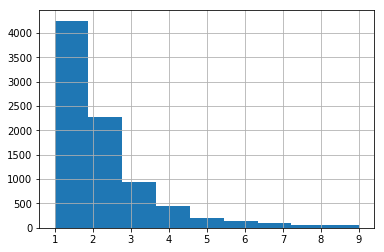

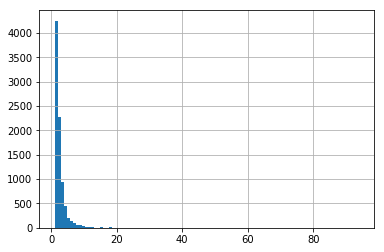

In [6]:
print('All fraud instance',all_data.fraud_ind.sum(skipna=True))
print('{} different bacno'.format(bacno_fraud_count[bacno_fraud_count>0].shape[0]))

bacno_fraud_count[(bacno_fraud_count<10)&(bacno_fraud_count>0)].hist(bins=9)
plt.show()
plt.clf()
bacno_fraud_count[(bacno_fraud_count>0)].hist(bins=100)

## 幾乎都只被騙過一兩次

In [7]:
list1=['locdt','cano','etymd','mchno','acqic','mcc','stocn','conam','fraud_ind']
list2=['locdt','conam','cano','ecfg','stscd','stocn','mchno','fraud_ind']
list3=['locdt','conam','cano','stocn','scity','flbmk','csmcu','ecfg','fraud_ind']
list4=['locdt','cano','mcc','etymd','stocn','scity','csmcu','fraud_ind']
# 
# ,'ecfg','etymd'
bacno_10fraud_more_list = bacno_fraud_count[(bacno_fraud_count==1)].index
pd.set_option('display.max_rows', 1000)
# print(x)
# pd.reset_option('display.max_rows')

cnt=0
for b in bacno_10fraud_more_list:
    cnt+=1
    if cnt>300:
        break
    print()
    
    print(b,all_data[all_data['bacno']==b]['fraud_ind'].sum())
    if all_data[all_data['bacno']==b]['ecfg'].sum()>=0:
        print(all_data[all_data['bacno']==b][list2].sort_values(by=['locdt']))
        
#     print(all_data[all_data['bacno']==b][list4].sort_values(by=['locdt']))


2 1.0
     locdt    conam    cano  ecfg  stscd  stocn   mchno  fraud_ind
11       1   541.07   96923     0      0    102   77960        0.0
12       1   151.14   96923     0      0    102   30194        0.0
13       1   683.25   96923     0      0    102   87352        0.0
14       2   177.04   96923     0      0    102   30194        0.0
15       2   435.32   96923     0      0    102   77960        0.0
16       2   365.63   96923     0      0    102   77960        0.0
17       2   969.14   96923     0      0    102   87352        0.0
21       5   743.53  101555     0      0    102   93829        0.0
20       5  2291.16  101555     1      0    102   53657        0.0
18       5   499.21   96923     0      0    102   77960        0.0
19       5   288.05   96923     0      0    102   30194        0.0
22       6   229.88   96923     0      0    102   89739        0.0
23       7   170.00   96923     0      0    102   77960        0.0
24       7   229.88   96923     0      0    102   30194

      locdt    conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
4218     22   513.80  22907     0      0    102  59369        0.0
4219     34   513.80  22907     0      0    102  59369        0.0
4220     40     0.00  22906     1      0     38  54238        0.0
4221     40  1016.34  22906     1      0     38  54238        1.0
4222     70   913.11  22908     0      0    102  15197        0.0
4223     70  1034.30  22908     0      0    102  74625        0.0
4224     83   465.62  22907     0      0    102      0        0.0

512 1.0
      locdt    conam    cano  ecfg  stscd  stocn   mchno  fraud_ind
5234      4     1.38  146866     0      0    102   38390        0.0
5235     11   724.05  146866     1      0    102   34176        0.0
5236     11  1680.34  146866     1      0    102   34239        0.0
5237     12   827.05  146866     1      0    102   38774        0.0
5238     15   652.03  146866     0      0    102   74331        0.0
5239     22    96.34  146866     1      2     27  10212

       locdt    conam   cano  ecfg  stscd  stocn   mchno  fraud_ind
13325     12     0.00  12224     0      0    104  102979        0.0
13326     23   598.80  12224     1      0    102   20023        0.0
13327     43   772.62  12224     1      0    102   84286        0.0
13328     46  1323.49  12224     1      0     20   44816        1.0
13329     57   981.75  12225     1      0    102   20437        0.0

1337 1.0
       locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
13349     23   446.15  161453     0      0    102  13631        0.0
13350     32  1208.10  161453     0      0    102  60275        0.0
13351     32  1638.28  161453     0      0    102  60275        0.0
13352     32   799.24  161453     0      0    102  60275        0.0
13353     68     0.00  161453     0      0    102  20292        0.0
13354     68     0.00  161453     0      0    102  20292        0.0
13355     68     0.00  161453     0      0    102  20292        0.0
13356     69     0.00  161453     0   

       locdt    conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
23087      7   976.75  78610     0      0    102  16610        0.0
23088     11   828.85  78610     0      0    102  91157        0.0
23089     11  1191.56  78610     0      0    102  53140        0.0
23090     13  1292.08  78610     0      0    102  39562        0.0
23091     16   884.33  78610     0      0    102  52304        0.0
23092     16  1053.99  78610     0      0    102  13021        0.0
23093     16   802.73  78610     0      0    102  16614        0.0
23094     23     0.00  78610     1      0     93  20984        0.0
23095     23  1145.76  78610     1      2      6  58820        1.0
23096     56   884.33  78611     0      0    102  90924        0.0
23097     58  1118.29  78611     0      0    102  52728        0.0
23098     80  1182.34  78611     0      0    102  39554        0.0
23099     89   612.83  78611     0      0    102  38255        0.0
23100     89   228.54  78611     0      0    102  78017       

       locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
29323     20   794.93  190752     0      0    102  18419        0.0
29324     27   103.22  190752     1      2    104  68107        1.0
29325     28  1198.52  190751     0      0    102   1172        0.0
29326     42     1.38  190753     1      0    102  79246        0.0
29327     42   880.07  190753     1      0    102  79200        0.0
29328     47   956.15  190751     0      0    102  36964        0.0
29329     72   522.58  190753     1      0    102  52139        0.0
29330     72   547.53  190751     1      0    102  31442        0.0
29331     86   764.38  190751     0      0    102   3123        0.0

3014 1.0
       locdt   conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
29333      6  220.35  91001     0      0    102   3221        0.0
29334     20    0.00  91001     0      0     46  54828        0.0
29335     32  633.15  91001     1      0    102  92863        0.0
29336     34  232.52  91001     0      0    10

       locdt   conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
38701     20  606.55  109813     0      0    102  38729        0.0
38702     53  606.55  109813     0      0    102  38729        0.0
38703     71  941.87  109813     0      0     42   6449        0.0
38704     71  554.80  109813     0      0     42   6449        0.0
38705     82  407.87  109813     1      0     46  54828        1.0

4193 1.0
       locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
39473      1  1128.21  203907     0      0    102  12963        0.0
39474      2  1144.79  203907     0      0    102  35806        0.0
39475      5  1015.19   21976     0      0    102  16615        0.0
39476      5   590.85  203907     1      0    102  34290        0.0
39477      6   531.12  203907     0      0    102  34752        0.0
39478      7   581.63  203907     1      0    102  77061        0.0
39479      7   520.41  203907     1      0    102  77061        0.0
39480      7   461.93  203907     1      0  

       locdt    conam    cano  ecfg  stscd  stocn   mchno  fraud_ind
53143      3   761.58  162270     1      0     44   33794        0.0
53144      4   151.14  162270     0      0    102   92739        0.0
53145      5  1144.01  162270     0      0    102   17751        0.0
53146      5  1110.00  162270     0      0    102   92327        0.0
53147      9     0.00  162270     0      0     38   54238        0.0
53148     10   253.80  162270     0      0    102       0        0.0
53149     15   519.10  162270     1      0    102   34179        0.0
53150     18   387.93  162270     0      0     75   65476        0.0
53151     18  1016.34  162270     1      0     38   54238        1.0
53153     19   655.51  162270     0      0    102   92551        0.0
53152     19   618.99  162270     1      0    102   34188        0.0
53154     26   201.39  162270     1      0    102    1958        0.0
53155     39     0.00  162271     0      0    102   59690        0.0
53156     39     0.00  162271     

       locdt    conam    cano  ecfg  stscd  stocn   mchno  fraud_ind
58874      3  1224.90  106106     0      0    102   86804        0.0
58875      3   193.61  106106     0      0    102   78073        0.0
58876      4   545.53  106106     0      0    102   77993        0.0
58877      7     0.00  106105     0      0    104  102979        0.0
58878      7   931.71  106105     1      0    102   36680        0.0
58879      7   804.62  106105     1      0     48     229        0.0
58880     10  1014.53  106105     1      0     93   21009        0.0
58881     11  1567.30  106105     1      2      6   55481        1.0
58882     12   770.32  187246     0      0    102   92648        0.0
58883     13   847.36  106106     0      0    102   77993        0.0
58884     17  1004.48  106106     0      0    102   77993        0.0
58885     19  2291.55  106107     1      0    102   77859        0.0
58886     22  1918.30  106107     1      0    102   34179        0.0
58887     22     0.00  187246     

       locdt    conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
67688      3   103.48  67369     1      0     38  54238        0.0
67689      4   103.48  67369     1      0     38  54238        0.0
67690     11   753.99  67369     0      0    102  96217        0.0
67691     15   551.51  67369     1      0     38  54238        0.0
67692     15   407.87  67369     1      0     38  54238        0.0
67693     20  2095.50  67369     0      0    102  17034        0.0
67694     24   551.51  67369     1      0     38  54238        0.0
67695     24   643.17  67369     0      0    102  96306        0.0
67698     25   551.51  67369     1      0     38  54238        0.0
67697     25   658.39  67369     1      0     38  54238        0.0
67696     25   551.51  67369     1      0     38  54238        0.0
67699     27   551.51  67369     1      0     38  54238        0.0
67700     29   103.48  67369     1      0     38  54238        0.0
67701     30   551.51  67369     1      0     38  54238       

       locdt   conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
80538      1  585.21  36360     1      0    102  82033        0.0
80539      4  996.16  36360     1      0    102  78741        0.0
80540      6  945.41  36360     1      0    104  55807        1.0

8593 1.0
       locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
80639      7  1377.28  114223     1      0    102  85268        0.0
80640      9  1200.97  114223     1      0    102  30953        0.0
80641     15   664.07  114223     1      0    102  20434        0.0
80642     15   664.07  114223     1      0    102  20434        0.0
80643     22  1095.85  114223     0      0    102  22388        0.0
80644     23  1126.87  114223     0      0    102  35730        0.0
80645     30  1327.89  114223     0      0    102  64846        0.0
80650     34   652.61  114223     1      0    102  20434        0.0
80649     34  1115.54  114223     0      0    102   6506        0.0
80647     34   664.07  114223     1      0    

       locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
87459      4   768.42  158672     0      0    102  82174        0.0
87460      5   435.32  158672     0      0    102  76092        0.0
87461      5  1443.30  158672     0      0     17  50349        0.0
87462      5   908.70  158672     1      0    102   4403        0.0
87463      8   520.41  158672     0      0    102  53791        0.0
87464      9   362.61  158672     0      0    102  12488        0.0
87465     12   324.18  158672     0      0    102  49267        0.0
87466     12   419.22  158672     0      0     52  68532        0.0
87467     14   349.66  158672     0      0     52  71505        0.0
87468     16   866.68  158672     0      0    102  48784        0.0
87469     20   523.45  158672     1      0    102  84831        0.0
87470     20   595.02  158672     1      0    102  84831        0.0
87471     20   735.54  158672     1      0    102   1747        0.0
87472     27   513.36  158672     0      0    10

10307 1.0
       locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
95824     15   683.25  161068     0      0    102  80739        0.0
95825     17   646.74  161068     0      0    102  91068        0.0
95826     18   149.14  161068     0      0    102  83353        0.0
95827     18   366.38  161068     0      0    102  40973        0.0
95828     18   551.51  161068     0      0    102  40595        0.0
95829     22   551.51  161068     0      0    102  40593        0.0
95830     22   407.87  161068     0      0    102  80739        0.0
95831     24   684.85  161068     0      0    102  91068        0.0
95832     26   282.86  161068     0      0    102  98775        0.0
95833     26  1028.77  161068     0      0    102  72066        0.0
95835     30   726.90  161068     0      0    102  83054        0.0
95834     30   684.58  161068     0      0    102  83052        0.0
95836     31   860.40  161068     0      0    102  23696        0.0
95837     34   426.47  161068     0   

11055 1.0
        locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
101843      1   288.05  164226     0      0    102   6505        0.0
101844      2   702.72  164226     1      0    102  34290        0.0
101845      3  1118.92  164226     1      0    102  90222        0.0
101846      6   312.42  164225     0      0    102  79111        0.0
101847     10   637.43  164226     1      0    102  20082        0.0
101848     10   635.60  164226     1      0    102  78537        0.0
101849     10  1118.29  164226     0      0    102  88680        0.0
101850     11   198.31  164225     0      0    102  19309        0.0
101851     14   823.22  164226     0      0    102   6504        0.0
101852     17     0.00  164226     1      0     38  54238        0.0
101853     17   586.27  164226     1      0    102  38850        0.0
101854     19   193.61  164226     0      0    102  87019        0.0
101856     22   407.87  164226     0      0    102   6477        0.0
101855     22   158.92  

        locdt    conam   cano  ecfg  stscd  stocn   mchno  fraud_ind
110487      2   465.62  75176     0      0    102       0        0.0
110488      5   750.46  75176     0      0    102   91052        0.0
110489     11   989.38  75176     1      0    102   77859        0.0
110490     13  2750.85  75175     1      2     92   43127        1.0
110491     13  1883.92  75175     1      2     16  102269        0.0
110492     15   916.17  75176     0      0    102   35730        0.0
110493     16   599.14  75176     0      0    102   87970        0.0
110494     17   683.25  75176     0      0    102   84048        0.0
110495     17   451.69  75176     0      0    102    7511        0.0
110496     21   751.35  75176     0      0    102   91097        0.0
110497     23   465.62  75176     0      0    102       0        0.0
110498     25   275.39  75176     0      0    102   91096        0.0
110499     29   626.61  75176     0      0    102    5558        0.0
110500     36   762.89  75176     

In [8]:
list1=['locdt','cano','etymd','mchno','acqic','mcc','stocn','conam','fraud_ind']
list2=['locdt','conam','cano','ecfg','stscd','stocn','mchno','fraud_ind']
# 
# ,'ecfg'
bacno_10fraud_more_list = bacno_fraud_count[(bacno_fraud_count>=10)].index
pd.set_option('display.max_rows', 1000)
# print(x)
# pd.reset_option('display.max_rows')

cnt=0
for b in bacno_10fraud_more_list:
    cnt+=1
    if cnt>100:
        break
    print()
    
    print(b,all_data[all_data['bacno']==b]['fraud_ind'].sum())
    print(all_data[all_data['bacno']==b][list2].sort_values(by=['locdt']))


75 13.0
     locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
890     12     0.00  163973     0      0     38  54238        0.0
891     12   177.04  163973     1      0     38  54238        1.0
892     12   300.06  163973     1      0     38  54238        1.0
893     13   300.06  163973     1      0     38  54238        1.0
894     13   300.06  163973     1      0     38  54238        1.0
895     13   300.06  163973     1      0     38  54238        1.0
896     23   177.04  163973     1      0     38  54238        1.0
897     25  1652.94  163974     0      0    102  78638        0.0
904     26   380.23  163973     1      0     38  54238        1.0
903     26   380.23  163973     1      0     38  54238        1.0
901     26   300.06  163973     1      0     38  54238        1.0
902     26   300.06  163973     1      0     38  54238        1.0
899     26   300.06  163973     1      0     38  54238        1.0
898     26   177.04  163973     1      0     38  54238        1.0
9

        locdt    conam    cano  ecfg  stscd  stocn   mchno  fraud_ind
197585      1   425.87  118949     0      0    104   64364        0.0
197586      1   342.90  118949     1      0    104   11775        0.0
197587      2   803.12  118949     0      0    104   20860        0.0
197588      2  1515.74  118949     1      0    104   11032        0.0
197589      2   443.34  118949     0      0    104   12292        0.0
197590      2   353.34  118949     1      0    104   11775        0.0
197591      3   236.43  118949     0      0    104   12279        0.0
197592      3   655.80  118949     0      0    104   64361        0.0
197593      3   342.90  118949     1      0    104   11775        0.0
197594      4   572.15  118949     0      0    104   68269        0.0
197595      4   366.38  118949     1      0    104   55714        0.0
197600      5   655.22  118949     0      0    104   64070        0.0
197598      5   342.90  118949     1      0    104   11775        0.0
197599      5   640.

197702     71     0.00  118950     0      0    104  102979        0.0

21978 18.0
        locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
202950      1   366.38  202802     1      0     92  67613        0.0
202951     13   697.89   54913     0      0    102  78006        0.0
202952     13   280.75   54913     0      0    102  78006        0.0
202953     19  1872.59   54913     0      0    102  77497        0.0
202954     19   793.55   54914     1      0    102  12442        0.0
202955     32   367.13  202802     1      0     92  67613        0.0
202958     41   171.79   54913     0      0    102  78006        0.0
202959     41  1027.65   54913     0      0    102  78006        0.0
202956     41   465.62   54913     0      0    102      0        0.0
202957     41   834.23   54914     0      0    102  77497        0.0
202970     57   664.63  202802     0      0    104  73732        1.0
202977     57  1451.28  202802     0      0    104  64602        1.0
202976     57   820.8

        locdt    conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
430233      5   733.68  55762     1      0    102  34227        0.0
430234      5   733.68  55762     1      0    102  34227        0.0
430235      9   728.78  55762     1      0    102  34253        0.0
430236      9   682.99  55762     1      0    102  34227        0.0
430237     11   667.15  55762     1      0    102  34227        0.0
430238     11   667.15  55762     1      0    102  34227        0.0
430239     21   783.94  55762     1      0    102  34227        0.0
430240     21   719.01  55762     1      0    102  34227        0.0
430241     35   917.48  55762     1      0    102  34229        0.0
430242     41   680.04  55762     1      0    102  34227        0.0
430243     41   680.04  55762     1      0    102  34227        0.0
430244     47   884.17  55762     1      0    102  12649        0.0
430246     49   667.15  55762     1      0    102  34227        0.0
430245     49   667.15  55762     1      0    10

        locdt    conam    cano  ecfg  stscd  stocn   mchno  fraud_ind
688778      2     0.00  192292     0      0    102   57804        0.0
688779      2     0.00  192292     0      0    104  103106        0.0
688780      2     0.00  192292     0      0     38   54238        0.0
688781      2     0.00  192292     0      0    104  103106        0.0
688782      4   513.80  192292     0      0    102     544        0.0
688783      4  1591.43  192292     0      0    102   78724        0.0
688784      5   216.12  192292     0      0    102   13011        0.0
688785     11   149.14  192292     0      0    102   82923        0.0
688786     12   513.80  192292     0      0    102     507        0.0
688787     20   513.80  192292     0      0    102     544        0.0
688788     22   513.80  192292     0      0    102     507        0.0
688789     25   465.62  192292     0      0    102       0        0.0
688790     25   513.80  192292     0      0    102     544        0.0
688791     27   513.

        locdt    conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
870019      1  1214.31  85447     0      0    102   6506        0.0
870020      2  1187.41  85447     0      0    102  51382        0.0
870021      4  1227.44  85447     0      0    102  22285        0.0
870022      5    74.77  85446     1      0    102  79245        0.0
870023      5  1162.62   2802     0      0    102  25903        0.0
870024      5  1095.94  85447     0      0    102  14582        0.0
870025      6   216.12   2802     1      0     46  54828        1.0
870026     10  1346.07   2802     0      0    102  51382        0.0
870027     10    74.77  85446     1      0    102  79245        0.0
870028     12   646.15  85447     0      0    102  38254        0.0
870029     13  2133.02  85447     0      0    102  13072        0.0
870030     13  1264.73  85447     0      0    102  30623        0.0
870031     14  1016.34   2802     1      0     46  54828        1.0
870058     15  1016.34   2802     1      2     4

曾經在該國被盜刷的紀錄
曾經在該mchno被盜刷的紀錄
曾經在該mchno被盜刷
最後一筆是不是盜刷


### 檢查在test data中,新出現的類別有多少
bacno, mchno, acqic, mcc, stocn, scity, csmcu 

In [9]:
def find_new_category(x,target_name):
    x_train = x[x['locdt']<=90][target_name].unique()
    x_test = x[x['locdt']>90][target_name].unique()
    
    print(target_name)
    print('{} categories in Training data:'.format(x_train.shape[0]))
    print('{} categories in Testing data:'.format(x_test.shape[0]))

    x_new_test=[]
    for b in x_test:
        if b not in x_train:
            x_new_test.append(b)

    print('{} new categories'.format(len(x_new_test)))    

In [10]:
## 幾乎所有在test data的都是新用戶 乾
## 所以重點特徵工程不能使用用戶過去的fraud記錄
find_new_category(all_data,'bacno')

## 幾乎都太多只出現在test data上的新類別,這樣得轉換可以用來訓練(TODO)
find_new_category(all_data,'mchno')
find_new_category(all_data,'acqic')
find_new_category(all_data,'mcc')
find_new_category(all_data,'stocn')
find_new_category(all_data,'scity')
find_new_category(all_data,'csmcu')


bacno
95214 categories in Training data:
71099 categories in Testing data:
67971 new categories
mchno
89316 categories in Training data:
45501 categories in Testing data:
13467 new categories
acqic
6051 categories in Training data:
3748 categories in Testing data:
815 new categories
mcc
434 categories in Training data:
372 categories in Testing data:
26 new categories
stocn
103 categories in Training data:
87 categories in Testing data:
6 new categories
scity
5698 categories in Training data:
2857 categories in Testing data:
949 new categories
csmcu
72 categories in Training data:
57 categories in Testing data:
4 new categories


In [11]:
a = pd.Series([1,2,2,3,3])
pd.Series.mode(a)

0    2
1    3
dtype: int64

In [12]:
raw_data = pd.read_csv('../data/raw_data.csv',index_col=False)
FE_data1 = pd.read_csv('../data/FE_data1.csv',index_col=False)
FE_data3 = pd.read_csv('../data/FE_data3.csv',index_col=False)

FE_data1 = FE_data1.fillna(value=-1)
# FE_data3 = FE_data1.fillna(value=-1)

all_data = pd.concat([raw_data,FE_data1,FE_data3],axis=1)
print(raw_data.shape)
print(FE_data1.shape)
print(FE_data3.shape)
print(all_data.shape)

(1943452, 23)
(1943452, 42)
(1943452, 4)
(1943452, 69)


In [13]:
list1=['locdt','cano','etymd','mchno','acqic','mcc','stocn','conam','fraud_ind']

list2=['locdt','conam','cano','ecfg','stscd','stocn','mchno','fraud_ind']

bacno_10fraud_more_list = bacno_fraud_count[(bacno_fraud_count<=4)].index

cnt=0
for b in bacno_10fraud_more_list:
    cnt+=1
    if cnt>100:
        break
    print()
    
    print(b,all_data[all_data['bacno']==b]['fraud_ind'].sum())
    print(all_data[all_data['bacno']==b][list2].sort_values(by=['locdt']))


0 0.0
         locdt   conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
1704733    102  929.46  114775     0      0    102  87081        NaN

1 0.0
    locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
0       3   934.49  117264     0      0    102  53099        0.0
1       4   939.19  117264     1      0    102  90151        0.0
2      25  1267.47  117264     1      0    102  90151        0.0
3      30  1017.37  117264     0      0    102  12726        0.0
4      34   613.81  117264     0      0    102  92571        0.0
5      50   643.76  117264     0      0    102  92641        0.0
6      60   645.26  117264     0      0    102  92641        0.0
7      63  1621.54  117264     1      0    102  90151        0.0
8      68   954.83  117264     0      0    102  52334        0.0
9      68   954.83  117264     1      0    102  53416        0.0
10     79   857.56  117264     0      0    102  77986        0.0

2 1.0
     locdt    conam    cano  ecfg  stscd  stocn   mchno  frau

         locdt    conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
1556890     94     0.00  164530     0      0     93  20984        NaN
1556891     94  1383.61  164530     1      0     42  20987        NaN

28 0.0
     locdt    conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
337     10   647.33  19040     0      0    102  78069        0.0
338     18   620.27  19040     0      0    102  78069        0.0
339     33   825.23  19040     0      0    102  94891        0.0
340     38   195.19  19040     0      0    102  78069        0.0
341     43   228.54  19040     0      0    102  79187        0.0
342     45   777.19  19040     0      0    102  78057        0.0
343     54  1182.11  19040     0      0    102  24963        0.0

29 0.0
     locdt   conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
344     22  969.14  96948     0      0    102  53932        0.0
345     52  969.14  96948     0      0    102  53932        0.0
346     89  969.14  96948     0      0    102  53932        0.

     locdt    conam  cano  ecfg  stscd  stocn  mchno  fraud_ind
587      6   732.99   770     0      0    102  93765        0.0
588     12  1430.12   770     0      0    102  48821        0.0
589     41   513.80   770     0      0    102  69006        0.0
590     44  1215.95   770     0      0    102  36709        0.0
591     45   513.80   770     0      0    102   2126        0.0
592     52   708.73   770     0      0    102   2126        0.0
593     57   772.20   770     0      0    102  74606        0.0
594     69   736.00   770     0      0    102  93765        0.0
595     87   655.51   770     0      0    102   2126        0.0
596     90   513.80   770     0      0    102  86584        0.0

57 0.0
         locdt   conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
1699371    105  899.28  84760     1      0    102  93974        NaN
1699372    120  592.25  84760     0      0    102  93873        NaN

58 0.0
         locdt  conam    cano  ecfg  stscd  stocn  mchno  fraud_ind
1763881 

         locdt   conam   cano  ecfg  stscd  stocn  mchno  fraud_ind
1767731     96  884.33  50763     0      0    102    544        NaN
1767735    100  683.25  50763     0      0    102    544        NaN
1767734    101  884.33  50763     0      0    102    544        NaN
1767730    102  513.80  50763     0      0    102    544        NaN
1767733    107  513.80  50763     0      0    102    544        NaN
1767736    107  683.25  50763     0      0    102    544        NaN
1767737    107  513.80  50763     0      0    102    544        NaN
1767727    110  513.80  50763     0      0    102    544        NaN
1767728    120  513.80  50763     0      0    102    544        NaN
1767729    120  513.80  50763     0      0    102    544        NaN
1767732    120  513.80  50763     0      0    102    544        NaN

86 0.0
         locdt   conam    cano  ecfg  stscd  stocn   mchno  fraud_ind
1776022    100  513.80  213404     0      0    102     544        NaN
1776023    101    0.00  213404     0

In [ ]:
a=pd.DataFrame([[1,2,3],[2,3,4]])
def hi(s):
    return 1,2
x = a.groupby([0]).apply(hi)

In [ ]:
# print(x)
# print(a)
# b=(1,2)
print(list([*b]))
